In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint, Bounds
from omega.utils import set_color_cycler
from tqdm.autonotebook import tqdm

# custom imports
from trademetrics import metrics
from omega import Ticker

colors = set_color_cycler(num_colors=50)

C:\Users\aungs_c08ycsn\AppData\Local\Temp\ipykernel_4236\702463489.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
class MaxSharpe:

    def __init__(self, prices, rfr=0.03, tol=None, options=None, shorts=False):
        self.stocks = prices.columns.to_list()
        self.prices = prices
        self.rfr = rfr
        self.optimzed_weights = None
        self.tol = tol
        self.options = options
        self.shorts = shorts

    def optimize(self):

        initial_weights = np.array([1/len(self.stocks)] * len(self.stocks))
        bounds = [(-1, 1) if self.shorts else (0, 1) for _ in range(len(self.stocks))]
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(np.abs(w)) - 1})

        opt = minimize(
            self._objective_function,
            initial_weights,
            args=(self.prices, self.rfr),
            bounds=bounds,
            constraints=constraints,
            tol=self.tol,
            options=self.options
        )

        self.weights = opt.x
        self.sharpe = -self._objective_function(self.weights, self.prices, self.rfr)

    @staticmethod
    def _objective_function(weights, prices, risk_free_rate):

        def _calculate_portfolio_variance(covariance_matrix, weights):
            return weights @ covariance_matrix @ weights.T
        
        returns = np.log(prices).diff()[1:]
        covariance_matrix = returns.cov() * 252
        portfolio_returns = returns @ weights.T
        expected_return = np.mean(portfolio_returns) * 252
        portfolio_std = np.sqrt(_calculate_portfolio_variance(covariance_matrix, weights))
        return -(expected_return - risk_free_rate) / portfolio_std 

In [3]:
class MaxSharpeModel:

    def __init__(
            self, 
            stock_prices, 
            lookback=60, 
            rebalance=60, 
            risk_free_rate=0.03, 
            costs=0.002,
            shorts=False,
    ):
        self.stock_prices = stock_prices
        self.stocks = self.stock_prices.columns.to_list()
        self.stock_returns = stock_prices.pct_change()[1:]
        self.lookback = lookback
        self.rebalance = rebalance
        self.weights = self._init_weights_df(self.stock_returns)
        self.risk_free_rate = risk_free_rate
        self.costs = costs
        self.shorts = shorts

    def fit(self, disp=True):
        
        if disp:
            index = tqdm(self.stock_prices.index[self.lookback:])
        elif not disp:
            index = self.stock_prices.index[self.lookback:]
        
        for n, date in enumerate(index):
            past_prices = self.stock_prices.loc[:date][-self.lookback:]
            if n % self.rebalance == 0:
                opt = MaxSharpe(
                    past_prices, 
                    self.risk_free_rate,
                    shorts=self.shorts,
                )
                opt.optimize()
                self.weights.loc[date] = opt.weights
        
        self.stock_returns = self.stock_returns[self.lookback-1:]
        self.weights = self.weights.ffill().shift()[self.lookback:]
        self.returns, self.growth, self.transaction_costs, self.num_trades = self._calculate_returns(
            self.weights, self.stock_returns, self.costs
        )

    @staticmethod
    def _calculate_returns(weights, stock_returns, costs, name='max_sharpe_portfolio'):
        returns = (weights * stock_returns).sum(axis=1)
        returns.name = name
        growth = (1 + returns).cumprod() - 1
        signals = weights.diff()
        transaction_costs = costs * abs(signals).sum(axis=1)
        transaction_costs.name = 'transaction_costs'
        returns -= transaction_costs
        return returns, growth, transaction_costs, signals[1:].ne(0).sum().sum()

    @staticmethod
    def _init_weights_df(returns):
        return pd.DataFrame(columns=returns.columns, index=returns.index)

In [63]:
start = '2020-07-28'
end = '2023-07-28'

stocks = ['AAPL', 'MSFT', 'META', 'GOOGL', 'DIS', 'BX', 'TSLA', 'NVDA']
benchmark = 'SPY'
benchmark_prices = Ticker(benchmark).get_prices(start, end)
stock_prices = Ticker(stocks).bulk_prices(start, end)
benchmark_returns = benchmark_prices.pct_change()[1:]
stock_returns = stock_prices.pct_change()[1:]

[*********************100%***********************]  8 of 8 completed


In [64]:
model = MaxSharpeModel(stock_prices, 60, 60, shorts=True)
model.fit()

  0%|          | 0/695 [00:00<?, ?it/s]

In [65]:
model_2 = MaxSharpeModel(stock_prices, 60, 60, shorts=False)
model_2.fit()

  0%|          | 0/695 [00:00<?, ?it/s]

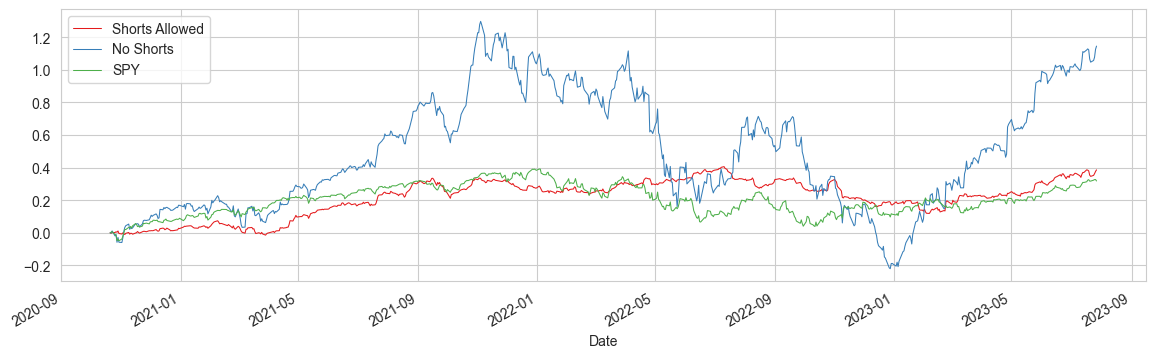

In [66]:
benchmark_growth = (1 + benchmark_returns.reindex(model_2.growth.index)).cumprod() - 1
ax = model.growth.plot()
model_2.growth.plot(ax=ax, c=colors[10])
benchmark_growth.plot(ax=ax, c=colors[15])
plt.legend(['Shorts Allowed','No Shorts', f'{benchmark}']);

In [67]:
stats = metrics.Metrics({
    'Max Sharpe Shorts': model.returns, 
    'Max Sharpe No Shorts': model_2.returns,
    f'{benchmark}': benchmark_returns.reindex(model_2.growth.index)
})
stats.calculate()

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
Max Sharpe Shorts,0.345714,0.115027,0.120076,0.791390,-0.209626
Max Sharpe No Shorts,1.087443,0.364534,0.441073,0.781127,-0.664868
SPY,0.317753,0.116739,0.182623,0.529717,-0.253606


In [95]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

stock = 'TSLA'

# Create a new dataframe with only the 'Close column 
data = stock_prices.filter([stock])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

658/658 [==============================] - 16s 19ms/step - loss: nan


In [92]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 [==============================] - 1s 10ms/step


1.9048288738887327

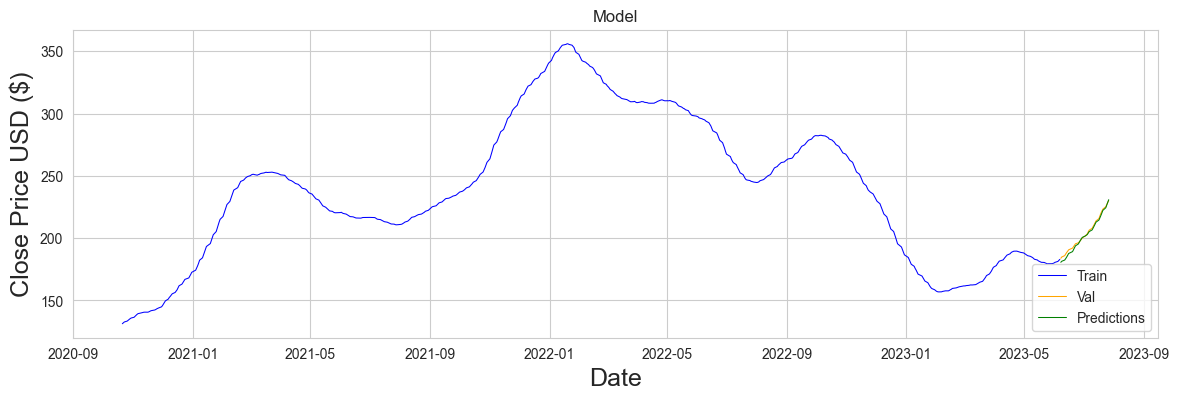

In [93]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train[stock], color='blue')
plt.plot(valid[stock], color='orange')
plt.plot(valid['Predictions'], color='green')
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<Axes: xlabel='Date'>

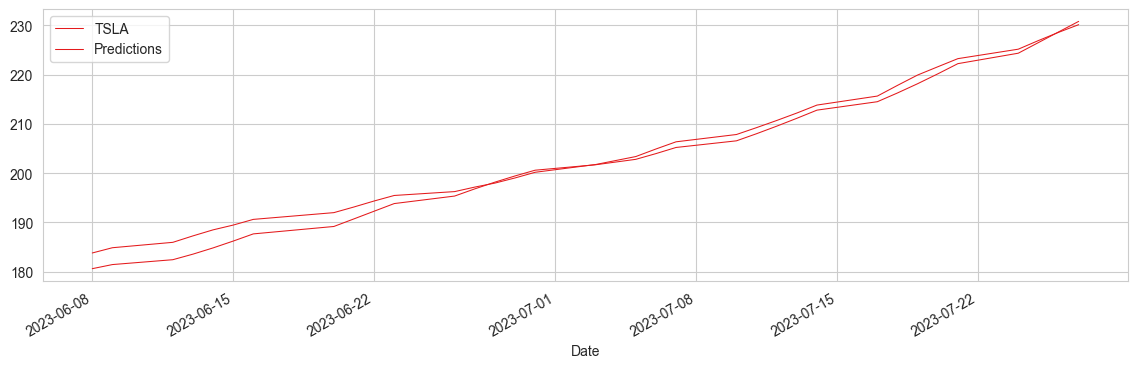

In [94]:
valid.plot()

In [85]:
len(train)

718

In [84]:
len(valid)

37

In [62]:
test_data

array([[0.73677208],
       [0.7307671 ],
       [0.74277705],
       [0.71222122],
       [0.71910976],
       [0.69155615],
       [0.73359233],
       [0.74065758],
       [0.73482932],
       [0.72052265],
       [0.71875661],
       [0.68307856],
       [0.70215321],
       [0.61931744],
       [0.62373308],
       [0.65269917],
       [0.66490714],
       [0.6054606 ],
       [0.58882989],
       [0.53327583],
       [0.57219918],
       [0.61607583],
       [0.59519894],
       [0.57007589],
       [0.56724534],
       [0.61359911],
       [0.58033769],
       [0.6098839 ],
       [0.60634526],
       [0.6054606 ],
       [0.57768357],
       [0.56582986],
       [0.55999135],
       [0.57379151],
       [0.546899  ],
       [0.58847592],
       [0.58865304],
       [0.60351444],
       [0.61041445],
       [0.59236839],
       [0.61430665],
       [0.66968386],
       [0.65482246],
       [0.66384522],
       [0.69286061],
       [0.66932988],
       [0.70188391],
       [0.731

<Axes: xlabel='Date'>

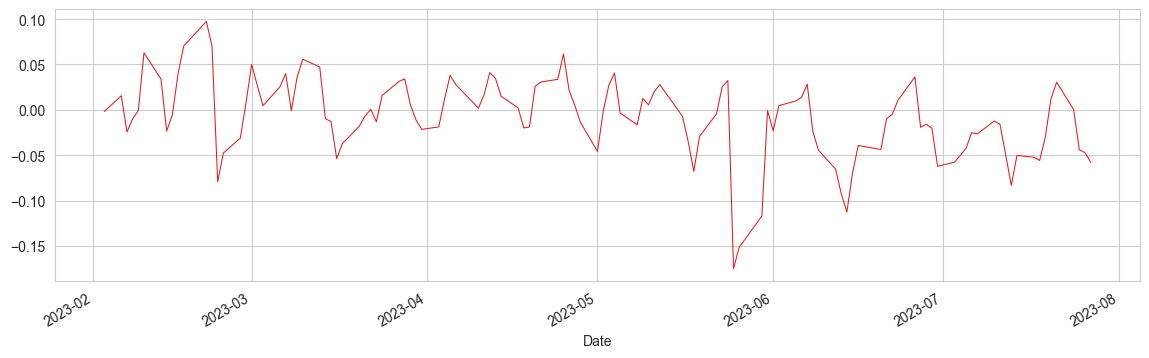

In [ ]:
(comparison.prediction/comparison.NVDA - 1).plot()

<Axes: xlabel='Date'>

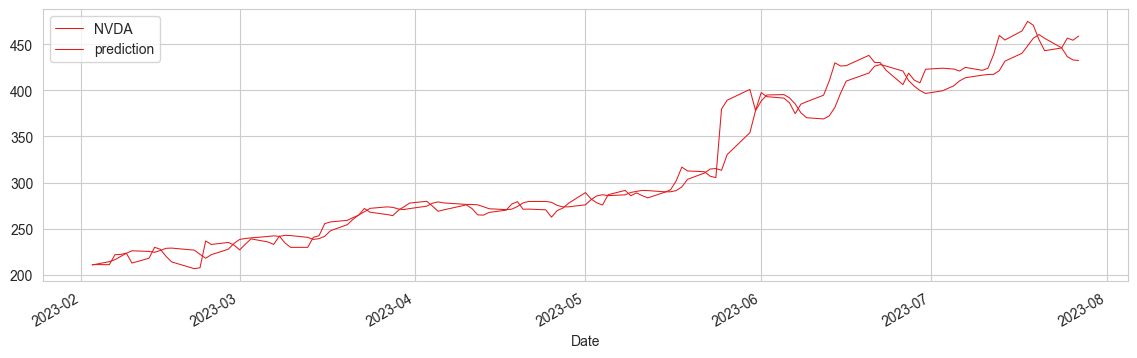

In [ ]:
compa

In [ ]:
len(predictions)

120

In [ ]:
a

NameError: name 'a' is not defined